# Import 

In [13]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from refnx.reflect import SLD, Slab, ReflectModel
from refnx.reflect import reflectivity, Structure
from refnx.analysis import CurveFitter, Objective, Parameter, GlobalObjective
from scipy.interpolate import interp1d
from matplotlib import gridspec
from refnx.dataset import Data1D
import MDAnalysis as mda
import pickle

import string
from tqdm import tqdm
%matplotlib inline
#%matplotlib qt
#import hplusminus as hpm
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
#matplotlib.rc('axes', labelsize=16)


# Functions 

## 1

In [3]:

def Reflectivity_input2(sld, layer_thickness, water_thickness_front, water_thickness_back,roughness):
    
    dz = np.abs(np.diff(sld[:,0])[0])#(sld[30,0] - sld[0,0]) / 30
    FrontWater = int(round( water_thickness_front / dz))
    BackWater = int(round(water_thickness_back / dz))
    Begin, End = FrontWater, len(sld)-BackWater 
    sld2 = np.zeros((End-Begin,2))
    sld2[:,1] = sld[Begin:End,1]
    sld2[:,0] = sld[Begin:End,0]
    number_of_slabs = round((max(sld2[:,0]) - min(sld2[:,0])) / layer_thickness ) +1
    number_of_slabs = int(number_of_slabs)
    ave= int(round(len(sld2) / number_of_slabs))# sld_points_in_a_slab 
    
    #################
    s = len(sld2)-number_of_slabs*ave
    d = int(np.floor((s/ave)))
    SLD2=np.zeros((len(sld2)-ave,2))
    SLD2[:,0] = sld2[0:len(sld2)-ave,0]
    ###########---------------
    j = 0
    SLD_layer=[]
    for i in range(0,number_of_slabs+d):
        sld_slab = sum(sld2[j:j+ave,1])/ave
        SLD2[j:j+ave,1]=sld_slab
        j=j+ave
        SLD_layer.append(sld_slab)
        
    
    Ref = np.zeros((len(SLD_layer),4))
    
    for i in range(0,len(Ref)):
        Ref[i][0] = layer_thickness 
        Ref[i][1] = SLD_layer[i]
        Ref[i][2] = 0  #sld_slab[i]
        Ref[i][3] = roughness  #2.0*random.random()-0.5#sld_slab[i]]
        
    #sld_slab2[0:Interface] = 0    
    return Ref, SLD2

def interpolate(sld,points):
    size = np.shape(sld)
    sldinterpolated = np.zeros((points,size[1]))
    x = sld[:,0]
    sldinterpolated[:,0] = np.linspace(min(x),max(x),points)
    for j in range(1,size[1]):
        
        y=sld[:,j]
        f = interp1d(x, y, kind='linear')
        sldinterpolated[:,j]= f(sldinterpolated[:,0])
        
    return sldinterpolated

def Add_Silicon_and_stuff(sld2,Ref,Sld_extra_layer,FrontorBack):
    #Add extra layers to the existing SLD, the input of SLD_extra_layer is shown below
    # Sld_extra_layer = [[thickness1,sld1,im_sld1,roughness],[thickness2,sld2,im_sld2,roughness]]

    dz =  np.abs(np.diff(sld2[:,0])[0])
    Points = []

    for i in range(0,len(Sld_extra_layer)):
        points = round(Sld_extra_layer[i][0] / dz)
        Points.append(int(points))


    Newsld =  np.zeros((len(sld2)+sum(Points),2))

    if  FrontorBack == "front":
        Start = 0    
        Distance= np.linspace(min(sld2[:,0])-sum(Points)*dz,min(sld2[:,0]),sum(Points))

        Newsld[Start:sum(Points),0] = Distance 
        Newsld[sum(Points):len(Newsld),0] = sld2[:,0]


        for j, points  in enumerate(Points):

            Newsld[Start:points+Start,1] = Sld_extra_layer[j][1]
            Start+=points

        Newsld[sum(Points):len(Newsld),1] = sld2[:,1]

    if  FrontorBack == "back":
        Start = len(sld2)   
        Distance= np.linspace(max(sld2[:,0]),max(sld2[:,0])+sum(Points)*dz,sum(Points))
        
        Newsld[Start:Start+sum(Points),0] = Distance 
        Newsld[0:Start,0] = sld2[:,0]


        for j, points  in enumerate(Points):
            
            Newsld[Start:points+Start,1]= Sld_extra_layer[j][1]
            Start+=points

        Newsld[0:len(sld2),1] = sld2[:,1]

    if sum(Points)!=0 and FrontorBack == 'front':
        Ref2 = np.zeros((len(Ref)+len(Sld_extra_layer),4))
        for i in range(0,len(Sld_extra_layer)):
            
            Ref2[i] = Sld_extra_layer [i]
        Ref2[i+1:len(Ref2)] = Ref 
          #2.0*random.random()-0.5#sld_slab[i]]

    if sum(Points)!=0 and FrontorBack == 'back':
        Ref2 = np.zeros((len(Ref)+len(Sld_extra_layer),4))
        for i in range(0,len(Sld_extra_layer)): Ref2[len(Ref):i+len(Ref)] = Sld_extra_layer [i]
        Ref2[0:len(Ref)] = Ref
    if sum(Points) == 0: return Ref
    return Ref2, Newsld

## 2

In [4]:

def Out_sld_at_this_deutration(SLD,deu_percentage):
    
    deu_percentage  /= 100
    sld_total      =  np.zeros((len(SLD),2))
    sld_total[:,0] =  SLD[:,0]
    sld_total[:,1] =  (SLD[:,1] - SLD[:,2]) + (1-deu_percentage)*SLD[:,4] + deu_percentage*SLD[:,2]
    
    return sld_total

def Reflectivity_From_SLD (SLD,remove_water,incident_intensity=1e8,AddSiliconInterface = True,
                         All_atom=False,sld=False,deutration_level=38, sio2_thickness = 10,
                          return_class=False,AnyDeutration=False,
                          substrate_structure=False):
    
    
    layer_thickness = 1.0
    roughness, thickness = 0.6, sio2_thickness# of silicondioxide interface
    remove_water_front = 0
    remove_water_back  = 2 # zero 
    
    q = np.linspace(0.0001,0.3,500)

    Rq_noise = np.zeros((len(q),3))
    Rq_noise [:,0] = q
    bkg = 1e-8

    try:
           
        sld_total = np.zeros((len(SLD), 2))  ## Deutrium percentage is defined here
        sld_total [:,0] = SLD[:,0]
        sld_total [:,1] = SLD[:,1]
        sld_total [:,1] *= 10
            
        
        ## The two numbers are back water and layer roughness
        remove_water_front=remove_water
        Ref, Sld2 = Reflectivity_input2(sld_total, layer_thickness, remove_water_front,remove_water_back,0.0)
        
        ###incase the rna is not on the side of majority

        #################################################


        if AddSiliconInterface:
            
            if substrate_structure: 
                
                Substrate = substrate_structure
                
                s = np.shape(Substrate.slabs())
                Sld_substrate = np.zeros((s[0]-1,s[1]-1))
                for i in range(0,len(Substrate.slabs())-1): Sld_substrate[i] = Substrate.slabs()[i][0:4]

                Ref[0][3] =  Substrate.slabs()[i+1][3]
                Ref, Sld2 =  Add_Silicon_and_stuff(Sld2,Ref,Sld_substrate,'front')
            
            else:

            #------_Adding silicon substrate
                #roughness = 2.0# temporrary
                Silicon = Slab(5.0, 2.07, roughness,name='silicon')
                SiO2 = Slab(thickness, 3.41, roughness,name='Sio2')

                Substrate = Silicon | SiO2 

                #SLD_extra = Str.sld_profile();
                s = np.shape(Substrate.slabs())
                Sld_substrate = np.zeros((s[0],s[1]-1))

                for i in range(0,len(Substrate.slabs())): Sld_substrate[i] = Substrate.slabs()[i][0:4]

                Ref[0][3] = roughness
                Ref, Sld2 = Add_Silicon_and_stuff(Sld2,Ref,Sld_substrate,'front')


        Str=[]
        
        for i in range(0,len(Ref)):
            c=Slab(Ref[i][0], Ref[i][1], Ref[i][3])
            Str.append(c)

        structure = Structure(Str)

        R_calculated = ReflectModel(structure,dq=5,bkg=0)


        Rq = R_calculated(q)
        Rq_noise [:,1] = Rq


        

        Rq = R_calculated(q)
        Var = ( Rq + Rq**2 ) / incident_intensity
        Rq_new = []
        Rq_new2 = []
        for i in range(0,len(Rq)):
            mu, sigma = Rq[i], np.sqrt(Var[i]) # mean and standard deviation
            random_noise=-1.0
            while(random_noise<0):
                random_noise = random.choice(np.random.normal(mu, sigma, 1000))
            #Rq_new.append(random.choice(np.random.normal(mu, sigma, 1000)))
            Rq_new.append(random_noise)

        Rq_noise[:,2] = np.array(Rq_new)# + 1e-9

        if sld: return structure
        if return_class: return R_calculated
        return Rq_noise
    
    except(OSError):
        
        print('file %s not found in %s' %(filename, path))
        return 0

    
def SLD_with_silicon_interface(sld_total):
    
    layer_thickness = 1.0
    roughness, thickness = 0.6,5.0 # of silicondioxide interface
    remove_water_front = 60#57
    remove_water_back = 10
    
    
    Ref, Sld2 = Reflectivity_input2(sld_total, layer_thickness, remove_water_front,remove_water_back,0.0) 
    #------_Adding silicon substrate

    Silicon = Slab(5.0, 2.07, roughness,name='silicon')
    SiO2 = Slab(thickness, 3.41, roughness,name='Sio2')

    Substrate = Silicon | SiO2 

    s = np.shape(Substrate.slabs())
    Sld_substrate = np.zeros((s[0],s[1]-1))

    for i in range(0,len(Substrate.slabs())): Sld_substrate[i] = Substrate.slabs()[i][0:4]

    Ref[0][3] = roughness
    Ref, Sld2 = Add_Silicon_and_stuff(Sld2,Ref,Sld_substrate,'front')


    Str=[]
    for i in range(0,len(Ref)):
        c=Slab(Ref[i][0], Ref[i][1], Ref[i][3])
        Str.append(c)

    structure = Structure(Str)
    
    return structure




def axis(ax,ref,fs=20,legend=True):
    
    font = fs
    fonttick = fs
    
    ax.tick_params(direction='in', length=4, width=2, colors='k',
               grid_color='r', grid_alpha=0)
    if ref=='ref':
        plt.xlabel('q [$\AA^{-1}$]',fontsize=font)
        plt.xticks(fontsize=fonttick)
        plt.ylabel('R (q)',fontsize=font)
        plt.yticks(fontsize=fonttick)
        if legend:
            plt.legend(fontsize=font)
    if ref=='sld':
        plt.xlabel('d $[\AA]$',fontsize=font)
        plt.xticks(fontsize=fonttick)
        plt.ylabel('SLD [$x 10^{-6}\AA^{-2}]$',fontsize=font)
        plt.yticks(fontsize=fonttick)
        if legend:
            plt.legend(fontsize=font)
        
        
    if ref=='fq':
        plt.xlabel('q [$\AA^{-1}$]',fontsize=font)
        plt.xticks(fontsize=fonttick)
        plt.ylabel('|F (q)| [$x 10^{-5}\AA^{-1}]$',fontsize=font)
        plt.yticks(fontsize=fonttick)
        if legend:
            plt.legend(fontsize=font)
        
    return plt


def remove_water_alpha(sld, thickness, water_fraction1 = 1.0,water_fraction2 = 1.0,
                       solvent ='D2O',AnyDeutration=False,deutration_level = 42,
                      Full_profile=False):
    
    # 38% D2O corresponds to CMSi
    
    if solvent=='D2O' or solvent=='cmsi' or solvent=="d2o" : index1, index2 = 3, 4
    
    if solvent=='H2O' or solvent=='h2o': index1, index2 = 1, 2
   
    Sld_just_bilayer = sld [:,index1] - sld [:,index2]
    dz = np.diff(sld[:,0])[3]
    
    remove_until = int(thickness / dz)
    #print(remove_until)

    Sld_water_removed = sld[:,index2]

    Sld_water_removed [:remove_until] = 0

    Sld_water_removed [:int(len(sld)/2)] *= water_fraction1

    Sld_water_removed [int(len(sld)/2):] *= water_fraction2

    Final_sld = np.zeros((len(sld), 2))

    Final_sld [:,0] = sld[:,0]

    Final_sld [:,1] = Sld_water_removed + Sld_just_bilayer
    
    if AnyDeutration:
        deutration_level /= 100
        
        Sld_h2o_removed   =  sld[:,2]
        
        Sld_d2o_removed   =  sld[:,4]
        
        # render removed water/d2o to zeros
        Sld_h2o_removed [:remove_until] = 0
        
        Sld_d2o_removed [:remove_until] = 0
        
        Sld_h2o_removed [:int(len(sld)/2)] *= water_fraction1
        
        Sld_d2o_removed [:int(len(sld)/2)] *= water_fraction1
        
        if Full_profile:
            Sld_h2o_removed  *=  water_fraction1
        
            Sld_d2o_removed  *=  water_fraction1
            
        # final sld
        Final_sld = np.zeros((len(sld), 2))
        Final_sld [:,0] = sld[:,0]
        Final_sld [:,1] = Sld_just_bilayer + deutration_level * Sld_d2o_removed  + (1-deutration_level) *Sld_h2o_removed
    
    
    return Final_sld

def get_background (q, Rq, R_exp):
    Chi_square = []
    back = []
    for i in np.linspace (0,10000,500): back.append (i*1e-9)
    
    for b in back:
        R = Rq(q) + b
        chi_square = (np.log (R_exp [:,1]) - np.log( R))**2 #/ np.log(R_exp[:,2])**2
        
        chi_square = chi_square[np.logical_not(np.isnan(chi_square))]
        
        Chi_square.append(chi_square.sum())
    
    return back[np.argmin(Chi_square)]


def Silicon_position (path, filename=False, plot=False, SLD=False):
    
    silicon_t = 10 # Angstroms
    
    if not filename: sld = SLD
    
    else: 
        sld = np.genfromtxt(path+filename,skip_header=0)
        
        sld = interpolate(sld, int(1.5*len(sld)))
    
    
    
    indices = sld [:,0] < -25
    a = sld[indices,1] - sld[indices,2]
    x = np.where(a==0)
    index = max (x[0])

    silicon_position = sld[index,0] - sld[0,0]
    
    if plot:
        plt.plot(sld[:,0], 10*(sld[:,1] - sld[:,2]))
        plt.plot(sld[index,0], 10*a[index], 's',ms=5)
        ymax = 0.05
        plt.vlines(sld[index,0], 10*-0.04, 10*ymax, ls ='dashed')
    
    return silicon_position    


def Water_fraction (sim_path, sim_filename, exp_filename, silicon_position, AnyDeutration=False, plot=False,
                   structure=False, solvent="D2O"):
    
    exp_path = "./example-data/"
    
    remove_water = silicon_position
    
    parameter_space = np.linspace(0,1.0,100) # water fraction
    
    R_exp           = np.genfromtxt (exp_path + exp_filename)
    q               = R_exp [:,0]
    Chi_square      = []
    
    for water1 in tqdm(parameter_space):
        
        sld = np.genfromtxt(sim_path+sim_filename,skip_header=0)
 
        sld  = interpolate(sld,max(500, len(sld)))

        sld2 = remove_water_alpha(sld, thickness=remove_water, water_fraction1= water1, 
                                  water_fraction2=1.0, solvent=solvent, AnyDeutration=AnyDeutration)
        
        Rq   =  Reflectivity_From_SLD (sld2, All_atom = True, remove_water=remove_water, incident_intensity=1e6,
                                     return_class=True, substrate_structure=structure)
        
        a, b =  0,-1
       
        #chi_square = sum((R_exp [:,1] - Rq(q))**2/ R_exp [:,2]**2)/len(R_exp)
        chi_square = sum((R_exp [:,1] - Rq(q))**2/ R_exp [:,2]**2)/len(R_exp)
        Chi_square.append(chi_square)
        
    optimum_water_frac  = parameter_space [argmin(Chi_square)]
    
    
    if plot:
        plt.plot(parameter_space, Chi_square)
    
        plt.plot(parameter_space [argmin(Chi_square)], Chi_square[argmin(Chi_square)],marker='s',
                color='k', ms=8, alpha=0.5)

    print (f"min ($\chi^2${min(Chi_square)})") 
    
    return optimum_water_frac, Chi_square, parameter_space
    

## 3 

In [5]:
## A class to hold all the data after fitting
class All_optimum:

    def __init__ (self, Substrate_properties, Rq_global, Rq_local, Rq_exp, SLD_global,SLD_local, 
                  water_fraction, Optimum_water_fractions, Chi_squares):
        
        # Substrate properties
        self.substrate_details = Substrate_properties
        
        # Rq_experimental
        
        self.Rq_exp_d2o      =   Rq_exp ['d2o']
        
        self.Rq_exp_h2o      =   Rq_exp ['h2o']
        
        self.Rq_exp_cmsi     =   Rq_exp ['cmsi']
        
        # q
        self.q_d2o           =   Rq_exp ['d2o'][:,0]
        self.q_h2o           =   Rq_exp ['h2o'][:,0]
        self.q_cmsi          =   Rq_exp ['cmsi'][:,0]
                
        # Rq Results from global fitting
        
        self.Rq_d2o_global    =  Rq_global ['d2o']

        self.Rq_h2o_global    =  Rq_global ['h2o']

        self.Rq_cmsi_global   =  Rq_global ['cmsi']

        # Rq Results from local fitting
        self.Rq_d2o_local    =  Rq_local ['d2o']

        self.Rq_h2o_local    =  Rq_local ['h2o']

        self.Rq_cmsi_local   =  Rq_local ['cmsi']

        # SLD result global
        
        self.sld_d2o_global   =   SLD_global ['d2o']
        
        self.sld_h2o_global   =   SLD_global ['h2o']
        
        self.sld_cmsi_global  =  SLD_global ['cmsi']
        
        # SLD result local
        
        self.sld_d2o_local   =   SLD_local ['d2o']
        
        self.sld_h2o_local   =   SLD_local ['h2o']
        
        self.sld_cmsi_local  =  SLD_local ['cmsi']
        # Structures

        self.global_chi  = Chi_squares ['global1']
        self.d2o_chi     = Chi_squares ['d2o']
        self.h2o_chi     = Chi_squares ['h2o']
        self.cmsi_chi    = Chi_squares ['cmsi']
        
        # Water fraction
        self.water_fraction   = water_fraction
        
        # Optimum water fractions
        
        self.water_fraction_global =  Optimum_water_fractions ['global1']
        
        self.water_fraction_d2o    =  Optimum_water_fractions ['d2o']
        
        self.water_fraction_h2o    =  Optimum_water_fractions ['h2o']
        
        self.water_fraction_cmsi   =  Optimum_water_fractions ['cmsi']
        
        


## 5

In [6]:
def Silicon_position (path, filename=False, plot=False, SLD=False):
    
    silicon_t = 10 # Angstroms
    
    if not filename: sld = SLD
    
    else: 
        sld = np.genfromtxt(path+filename,skip_header=0)
        
        sld = interpolate(sld, int(1.5*len(sld)))
    
    
    
    indices = sld [:,0] < -25
    a = sld[indices,1] - sld[indices,2]
    x = np.where(a==0)
    index = max (x[0])

    silicon_position = sld[index,0] - sld[0,0]
    
    if plot:
        plt.plot(sld[:,0], 10*(sld[:,1] - sld[:,2]))
        plt.plot(sld[index,0], 10*a[index], 's',ms=5)
        ymax = 0.05
        plt.vlines(sld[index,0], 10*-0.04, 10*ymax, ls ='dashed')
    
    return silicon_position    


def Water_fraction (sim_path, sim_filename, exp_filename, silicon_position, AnyDeutration=False, plot=False,
                   structure=False, solvent="D2O"):
    
    silicon_t = 10 # fixed
    exp_path = "./"
    
    remove_water = silicon_position
    
    parameter_space = np.linspace(0,1.0,100) # water fraction
    
    R_exp           = np.genfromtxt (exp_path + exp_filename)
    q               = R_exp [:,0]
    Chi_square      = []
    
    for water1 in tqdm(parameter_space):
 
        sld  = interpolate(np.genfromtxt(sim_path+sim_filename,skip_header=0),500)

        sld2 = remove_water_alpha(sld, thickness=remove_water, water_fraction1= water1, 
                                  water_fraction2=1.0, solvent=solvent, AnyDeutration=AnyDeutration)
        
        Rq   =  Reflectivity_From_SLD (sld2, All_atom = True, remove_water=remove_water,
                                      sio2_thickness = silicon_t, incident_intensity=1e6,
                                     return_class=True, substrate_structure=structure)
        
        a, b =  0,-1
       
     
        chi_square = sum((R_exp [:,1] - Rq(q))**2/ R_exp [:,2]**2)/len(R_exp)
        Chi_square.append(chi_square)
        
    optimum_water_frac  = parameter_space [argmin(Chi_square)]
    
    
    if plot:
        plt.plot(parameter_space, Chi_square)
    
        plt.plot(parameter_space [argmin(Chi_square)], Chi_square[argmin(Chi_square)],marker='s',
                color='k', ms=8, alpha=0.5)

    print (f"min ($\chi^2${min(Chi_square)})")
    
    return optimum_water_frac, Chi_square, parameter_space
    
    

def Obtain_Substrate_parameters (Rq):
    
    
    ''' Rq: is the experimental reflectivity data taken for Si-D2O systems'''
    
    x, y, yerr = Rq [:,0], Rq [:,1],Rq [:,2] 
    data       = Data1D(data=(x, y, yerr))

    ''' Set initial parameters '''
    roughness =  2
    thickness =  5
    Silicon   =  Slab(5.0, 2.07, roughness,name='silicon') # fixed
    SiO2      =  Slab(thickness, 3.47, roughness,name='Sio2') # fixed
    D2O       =  Slab(thickness,6.2513,roughness,name='D2O') #varied 


    ''' Paramter bounds to vary within '''
    Silicon.rough.setp(bounds=(0, 2), vary=True)
    Silicon.sld.real.setp(bounds=(1.98, 2.1), vary=False)

    SiO2.thick.setp(bounds=(5, 10), vary=True)
    SiO2.rough.setp(2, bounds=(0, 2), vary=True)
    SiO2.sld.real.setp(bounds=(3.3, 3.55), vary=True)

    D2O.sld.real.setp(bounds=(6.0, 6.4), vary=True)
    D2O.rough.setp(bounds=(0, 2), vary=True)

    ''' Setup '''
    structure = Silicon | SiO2 | D2O


    ''' For fitting '''

    model = ReflectModel(structure, bkg=3e-6, dq=5.0)
    scale = np.average (Rq [:10,1]) 
    model.scale.setp(scale, bounds= (0.9, 1.1), vary=True)
    model.bkg.setp(bounds=(1e-9, 9e-6), vary=True)
    objective = Objective(model, data, transform=Transform('lin'))

    ''' Use differential evolution fitting procedure '''

    fitter = CurveFitter(objective)
    fitter.fit('differential_evolution', seed=42);

    return structure, objective

exp_path = "./"

## 6

In [7]:
def get_sld_water_patch_fraction (sld, f):
    
    sld_new = np.zeros (np.shape (sld))
    
    sld_new [:,0] = sld [:,0]
    
    # Bulk Slds
    
    bulk_h2o_sld = np.average (sld [-10:,2]) * np.ones (len (sld))
    bulk_d2o_sld = np.average (sld [-10:,4]) * np.ones (len (sld))
    ##print (bulk_h2o_sld, bulk_d2o_sld)
    
    just_bilayer_sld = sld [:,1] - sld [:,2]

    
    sld_new [:,1]  = (1-f)*just_bilayer_sld + (1-f)*sld [:,2] + f*bulk_h2o_sld
    
    sld_new [:,2]  = (1-f)*sld [:,2] + f*bulk_h2o_sld
    
    
    sld_new [:,3]  = (1-f)*just_bilayer_sld + (1-f)*sld [:,4] + f*bulk_d2o_sld
    
    sld_new [:,4]  = (1-f)*sld [:,4] + f*bulk_d2o_sld
    
    
    return sld_new



def Water_fraction_Water_patch (sim_path, sim_filename, exp_filename, silicon_position, AnyDeutration=False, plot=False,
                   structure=False, solvent="D2O"):
    
    exp_path = "./example-data/"
    
    remove_water = silicon_position
    
    water_patch = np.linspace(0, 0.5, 100)
    parameter_space1 = np.linspace(0,1.0,100) # water fraction
   
    parameter_space = [ (water1, water2) for water1 in parameter_space1 for water2 in water_patch]


    R_exp           = np.genfromtxt (exp_path + exp_filename)
    q               = R_exp [:,0]
    Chi_square      = []
    
    for water1, f in tqdm(parameter_space):
        

            sld  = np.genfromtxt(sim_path+sim_filename,skip_header=0)
            sld  = interpolate(sld,max (500, len(sld)))
            
            sld2 = remove_water_alpha_water_patch (sld, thickness=remove_water,patch_frac=f, water_fraction1= water1, 
                                      water_fraction2=1, solvent=solvent, AnyDeutration=AnyDeutration)


            Rq   =  Reflectivity_From_SLD (sld2, All_atom = True, remove_water=remove_water, incident_intensity=1e6,
                                         return_class=True, substrate_structure=structure)

            a, b =  0,-1

            #chi_square = sum((R_exp [:,1] - Rq(q))**2/ R_exp [:,2]**2)/len(R_exp)
            chi_square = sum((R_exp [:,1] - Rq(q))**2/ R_exp [:,2]**2)/len(R_exp)
            Chi_square.append(chi_square)
    
        
    optimum_parameters  = parameter_space [argmin(Chi_square)]
    
    
    if plot:
        plt.plot(parameter_space, Chi_square)
    
        plt.plot(parameter_space [argmin(Chi_square)], Chi_square[argmin(Chi_square)],marker='s',
                color='k', ms=8, alpha=0.5)

    print (f"min ($\chi^2${min(Chi_square)})") 
    
    return optimum_parameters, Chi_square, parameter_space

    
def get_chi_sqr (R_exp, R_sim, both_exp = False):
    

    chi_square = sum((R_exp [:,1] - R_sim [:,1])**2/ R_exp [:,2]**2)/ (len(R_exp)-1)
    
    if both_exp:
        sigma12 = R_exp [:,2]**2 + R_sim [:,2]**2
        chi_square = sum((R_exp [:,1] - R_sim [:,1])**2/sigma12 )/ (len(R_exp)-1)
    
    return chi_square


def get_chi_array (R_object, solvent=False):

    Chi_sq          =  np.zeros ((100,100))

    index = 0
    for i in range (100):

        for j in range (100):
            
            if solvent:
                
                if solvent == "h2o" or solvent =="H2O":  Chi_sq [i, j]  = R_object.h2o_chi [index]
                if solvent == "d2o" or solvent =="D2O":  Chi_sq [i, j]  = R_object.d2o_chi [index]
                if solvent == "cmsi" or solvent =="CMSi": Chi_sq [i, j] = R_object.cmsi_chi [index]
                
            else:
                
                Chi_sq [i, j] = R_object.global_chi [index]

            index += 1
            
    return Chi_sq

## Remove water, scale and correct for patch

In [8]:
def remove_water_alpha_water_patch (sld, thickness,patch_frac, water_fraction1 = 1.0,water_fraction2 = 1.0,
                       solvent ='D2O',AnyDeutration=False,deutration_level = 42,
                      Full_profile=False):
    
    # 38% D2O corresponds to CMSi
    dz = np.diff(sld[:,0])[3]
    
    remove_until = int(thickness / dz)
    
    identity_array = np.ones (len(sld))
    
    identity_array [:remove_until] = 0
    ## Obtain Bulk densities for each contrast
    
    deutration_level /= 100
    
    bulk_d2o   = np.average (sld [-10:,4])
    
    bulk_h2o   = np.average (sld [-10:,2])
    
    bulk_cmsi   = deutration_level*bulk_d2o + (1-deutration_level)*bulk_h2o
                  
                  
    
    if solvent=='D2O' or solvent=='cmsi' or solvent=="d2o":
        index1, index2 = 3, 4
        bulk_solvent_sld  = bulk_d2o*identity_array
    
    if solvent=='H2O' or solvent=='h2o':
        
        index1, index2 = 1, 2
        
        bulk_solvent_sld = bulk_h2o*identity_array
    
    if AnyDeutration:
        
        bulk_solvent_sld = bulk_cmsi*identity_array
    
                  
    Sld_just_bilayer = (1-patch_frac)*(sld [:,index1] - sld [:,index2]) + patch_frac*bulk_solvent_sld
    
    sld [:, 2] *= (1-patch_frac)
    sld [:, 4] *= (1-patch_frac)
    
    

    #print(remove_until)

    Sld_water_removed = sld[:,index2]

    Sld_water_removed [:remove_until] = 0

    Sld_water_removed [:int(len(sld)/2)] *= water_fraction1

    Sld_water_removed [int(len(sld)/2):] *= water_fraction2

    Final_sld = np.zeros((len(sld), 2))

    Final_sld [:,0] = sld[:,0]

    Final_sld [:,1] = Sld_water_removed + Sld_just_bilayer
    
    if AnyDeutration:
                
        Sld_h2o_removed   =  sld[:,2]
        
        Sld_d2o_removed   =  sld[:,4]
        
        # render removed water/d2o to zeros
        Sld_h2o_removed [:remove_until] = 0
        
        Sld_d2o_removed [:remove_until] = 0
        
        Sld_h2o_removed [:int(len(sld)/2)] *= water_fraction1
        
        Sld_d2o_removed [:int(len(sld)/2)] *= water_fraction1
        
        if Full_profile:
            Sld_h2o_removed  *=  water_fraction1
        
            Sld_d2o_removed  *=  water_fraction1
            
        # final sld
        Final_sld = np.zeros((len(sld), 2))
        Final_sld [:,0] = sld[:,0]
        Final_sld [:,1] = Sld_just_bilayer + deutration_level * Sld_d2o_removed  + (1-deutration_level) *Sld_h2o_removed
    
    
    return Final_sld

## 7

In [9]:

def Get_all_parameters_water_patch (exp_filename_d2o, exp_filename_h2o, exp_filename_cmsi, R_cell, sim_path,
                       sim_filename, exp_path="./", substrate=False):

    # Load experimental data
    
    R_exp_d2o    =  np.genfromtxt(exp_path + exp_filename_d2o)
    R_exp_h2o    =  np.genfromtxt(exp_path + exp_filename_h2o)
    R_exp_cmsi   =  np.genfromtxt(exp_path + exp_filename_cmsi)

  #  print (exp_filename_d2o)
    ''' Obtain substrate properties '''
    if not substrate: # This required to use the same subsrate incase of different FF comparions
        
        structure, objective =  Obtain_Substrate_parameters (Rq = R_cell)
        
    else:
        
        structure, objective = substrate ['structure'], substrate ['objective']
        
        
    silicon_position     =  Silicon_position (sim_path, sim_filename, plot=False)
    print (silicon_position)
    ''' Obtain optimum water fractions '''

    # H2o
    
    optimum_parameters_h2o, Chi_square_h2o, parameter_space =  Water_fraction_Water_patch (sim_path, sim_filename, exp_filename_h2o,
                                                                                       silicon_position, AnyDeutration=False, plot=False,
                                                                                       structure=structure, solvent="H2O")

    #D2O
    
    optimum_parameters_d2o, Chi_square_d2o, parameter_space =  Water_fraction_Water_patch (sim_path, sim_filename, exp_filename_d2o,
                                                                                   silicon_position, AnyDeutration=False, plot=False,
                                                                                   structure=structure, solvent="D2O")
    
    print (optimum_parameters_d2o, "D2O")

    # CMSi
    optimum_parameters_cmsi, Chi_square_cmsi, parameter_space =  Water_fraction_Water_patch (sim_path, sim_filename, exp_filename_cmsi,
                                                                                   silicon_position, AnyDeutration=True, plot=False,
                                                                                   structure=structure, solvent="D2O")



    ''' Get Local Rq and SLD '''

    # Get global chi square
    Chi_global = np.array (Chi_square_cmsi) + np.array(Chi_square_h2o) + np.array(Chi_square_d2o)

    # Global water fraction
    optimum_parameters_global = parameter_space [np.argmin (Chi_global)]



    Optimum_water_fractions = dict (h2o=optimum_parameters_h2o, d2o=optimum_parameters_d2o, cmsi=optimum_parameters_cmsi,
                                   global1=optimum_parameters_global)

    Rq_local                = dict (h2o=0, d2o=0, cmsi=0)

    Rq_exp                  = dict (h2o = R_exp_h2o, d2o=R_exp_d2o, cmsi=R_exp_cmsi)

    SLD_local               = dict (h2o = 0, d2o=0, cmsi=0)

    Chi_squares             = dict (global1=Chi_global, h2o=Chi_square_h2o, d2o=Chi_square_d2o, cmsi=Chi_square_cmsi)

    ''' Local Rq SLD assignments '''

    for solvent in ["h2o", "d2o", "cmsi"]:


        sld     = np.genfromtxt(sim_path+sim_filename, skip_header=0)
        sld     = interpolate(sld, max(500, len(sld)))
        
        water_patch_fraction = Optimum_water_fractions [solvent] [1]
                
        water1  = Optimum_water_fractions [solvent][0]
        

        AnyDeutration = False

        if solvent == "cmsi": AnyDeutration = True

        sld2    = remove_water_alpha_water_patch (sld, thickness=silicon_position, patch_frac=water_patch_fraction, water_fraction1= water1, water_fraction2=1, solvent=solvent, 
                                  AnyDeutration=AnyDeutration)

        Rq   =  Reflectivity_From_SLD(sld2, All_atom = True, remove_water=silicon_position, incident_intensity=1e6,
                                     return_class=True, substrate_structure=structure)



        SLD   =  Reflectivity_From_SLD(sld2, All_atom=True, sld=True,remove_water=silicon_position,
                                         substrate_structure=structure)

        q = Rq_exp[solvent][:,0]
        background  = get_background (q,  Rq, Rq_exp [solvent])

        Rq_ = np.zeros ((len(q), 2))
        # Rq
        Rq_ [:,0] = q
        Rq_ [:,1] = Rq(q) + background

        Rq_local [solvent] = Rq_

        SLD_ = np.zeros ((len(SLD.sld_profile()[0]), 2))

        SLD_ [:,0] = SLD.sld_profile()[0]
        SLD_ [:,1] = SLD.sld_profile()[1]
        SLD_local [solvent] = SLD_


    ''' Global assigments '''

    Rq_global              =  dict (h2o=0, d2o=0, cmsi=0)

    SLD_global             =  dict (h2o = 0, d2o=0, cmsi=0)

    Substrate_properties   =  dict (structure=structure, objective=objective, Rq_exp = R_cell)

    for solvent in ["h2o", "d2o", "cmsi"]:


        sld     = np.genfromtxt(sim_path+sim_filename, skip_header=0)
        sld     = interpolate(sld, max(500, len(sld)))
        water_patch_fraction = optimum_parameters_global [1]
        
        
        water1  = optimum_parameters_global [0] # Use the global water fraction

        AnyDeutration = False

        if solvent == "cmsi": AnyDeutration = True

        sld2    = remove_water_alpha_water_patch(sld, thickness=silicon_position, patch_frac= water_patch_fraction, water_fraction1= water1, water_fraction2=1, solvent=solvent, 
                                  AnyDeutration=AnyDeutration)

        Rq   =  Reflectivity_From_SLD(sld2, All_atom = True, remove_water=silicon_position, incident_intensity=1e6,
                                     return_class=True, substrate_structure=structure)



        SLD   =  Reflectivity_From_SLD(sld2, All_atom=True, sld=True,remove_water=silicon_position,
                                         substrate_structure=structure)

        q = Rq_exp[solvent][:,0]

        background = get_background (q,  Rq, Rq_exp [solvent])

        Rq_ = np.zeros ((len(q), 2))
        # Rq
        Rq_ [:,0] = q
        Rq_ [:,1] = Rq(q) + background

        Rq_global [solvent] = Rq_

        SLD_ = np.zeros ((len(SLD.sld_profile()[0]), 2))

        SLD_ [:,0] = SLD.sld_profile()[0]
        SLD_ [:,1] = SLD.sld_profile()[1]
        SLD_global [solvent] = SLD_



    All_params = All_optimum (Substrate_properties=Substrate_properties, Rq_exp=Rq_exp, Rq_global=Rq_global,Rq_local=Rq_local,
                             Optimum_water_fractions=Optimum_water_fractions, Chi_squares=Chi_squares,
                             water_fraction=parameter_space, SLD_global=SLD_global, SLD_local=SLD_local)
    
    return All_params





# Effect of $\gamma$ and $\alpha$ on the SLD profile


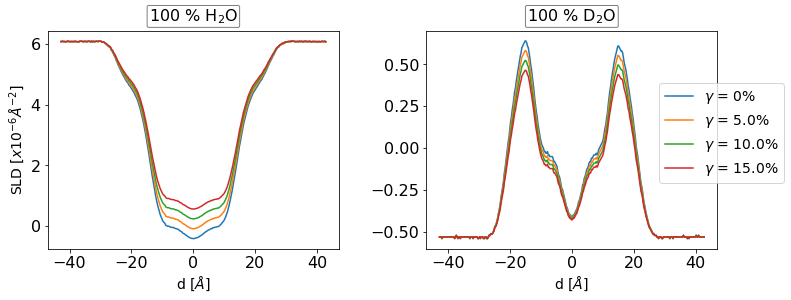

In [11]:
# Amber
out_path          = "./example-data/"
#sim_filename      =  "average.dat"
sim_filename      = "nsld_mc3h_dopc.dat"
sim_path          = "./example-data/"
silicon_position     =  Silicon_position (sim_path, sim_filename, plot=False)



fig   = plt.figure(figsize=(12,4))

gs    = fig.add_gridspec(nrows=1, ncols=2,width_ratios=[1,1] , wspace=0.3, hspace=0.3)

ax1 = fig.add_subplot(gs[0,0])
#ax1.set_xticks([0, 25,50,75])
#ax1.set_xlim(right=80, left=-9)


ax2 = fig.add_subplot(gs[0,1])
#ax2.set_xticks([0, 25,50,75])
#ax2.set_xlim(right=80, left=-9)
ax1.set_ylabel('SLD [$x 10^{-6}\AA^{-2}]$',fontsize=14)
ax1.set_xlabel('d [$\AA]$',fontsize=14)
ax2.set_xlabel('d [$\AA]$',fontsize=14)
#plt.plot (sld [:,0], sld [:,1], '.')
water1 = 1
solvent = "D2O"
for f in [0, 0.05, 0.1,0.15,]:
    
    sld     = np.genfromtxt(sim_path+sim_filename, skip_header=0)
    
    sld = get_sld_water_patch_fraction (sld, f)

    #sld2 = remove_water_alpha_water_patch (sld, thickness=silicon_position,patch_frac=f, water_fraction1= water1, 
   #                       water_fraction2=1, solvent=solvent, AnyDeutration=False, Full_profile=True)
    
    ax1.plot (sld [:,0], sld [:,3]*10 , label = "$\gamma$ = " + str (f*100) + "%")
    
    ax2.plot (sld [:,0], sld [:,1]*10 , label = "$\gamma$ = " + str (f*100) + "%")

#plt.xlim (0,30)
plt.legend (fontsize=14, loc = (0.8, 0.3)) 

ax1.set_title ("100 % H$_2$O", fontsize=font,bbox=dict(boxstyle="round,pad=0.1", fc="white", ec=None, lw=1, alpha=0.5),
                                  pad=10)
ax2.set_title ("100 % D$_2$O", fontsize=font,bbox=dict(boxstyle="round,pad=0.1", fc="white", ec=None, lw=1, alpha=0.5),
                                  pad=10)

plt.savefig ("./example-data/water_patch_demo.png", dpi=300, bbox_inches='tight') 


# Vary $\gamma$ and $\alpha$ to optimize simulation reflectivity 

1. $\gamma$ is the fraction of water patch area on the  bilayer <br>
2. $\alpha$ is the water fraction at the bilayer water interface 


In [22]:
path_exp = './example-data/'
path_amber_mc3h  = './example-data/'
sim_path = "./example-data/"
#D2O

# Load experimental data

exp_filename_d2o  =   './example-data/rq_exp_d2o.txt' 
exp_filename_cmsi =   './example-data/rq_exp_cmsi.txt'
exp_filename_h2o  =  './example-data/rq_exp_h2o.txt'

# Load the Silica-D2o reflectivity data to obtain the substrate SLD
R_cell =  np.genfromtxt('./example-data/rq_silica_d2o.txt')

#D2O


# Substrate
structure, objective =  Obtain_Substrate_parameters (Rq = R_cell)

substrate = dict (structure=structure, objective=objective)

#print (structure)

18it [00:03,  5.24it/s]


In [23]:
# Amber
ouput_object_name = "output_data.pkl"
out_path          = "./example-data/"
sim_filename      = "nsld_mc3h_dopc.dat"
sim_path          =  path_amber_mc3h

All_params = Get_all_parameters_water_patch(exp_filename_d2o, exp_filename_h2o, exp_filename_cmsi, R_cell, sim_path,
                       sim_filename, exp_path="./", substrate=substrate)
with open(out_path +ouput_object_name, 'wb') as outp: pickle.dump(All_params, outp, pickle.HIGHEST_PROTOCOL)




12.899999999999999


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [10:21<00:00, 16.09it/s]


min ($\chi^2$5.325326127489332)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [10:55<00:00, 15.26it/s]


min ($\chi^2$1.7889596806308616)
(0.5050505050505051, 0.025252525252525256) D2O


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [10:52<00:00, 15.34it/s]


min ($\chi^2$1.1658385999725325)


# Plot optimum SLD and reflectivty at each contrast

water fraction =  (0.5353535353535354, 0.05050505050505051)


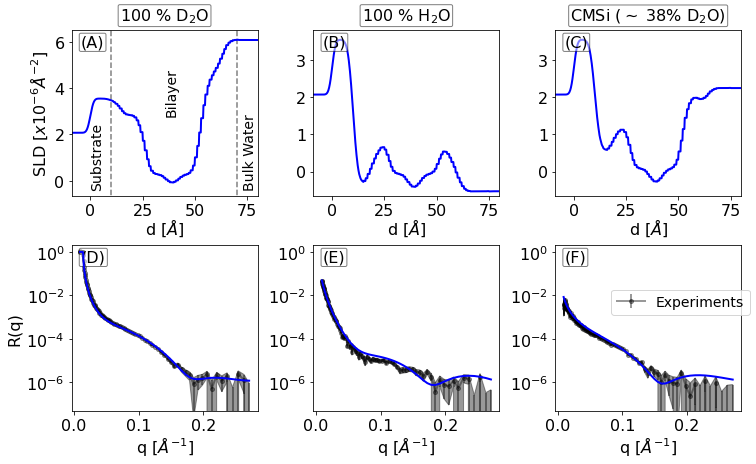

In [14]:
#ouput_object_name =  "mch_amber_15m.pkl"
ouput_object_name =  "output_data.pkl"
out_path          =  "./example-data/"
font              =  16

with open(out_path + ouput_object_name, 'rb') as inp: R_amber = pickle.load(inp)

#########


annotate_pos = (0.05,0.9)

fig   = plt.figure(figsize=(12,7))

gs    = fig.add_gridspec(nrows=2, ncols=3,width_ratios=[1,1,1] , wspace=0.3, hspace=0.3)

alpha = 0.4

''' SLD '''
# D2O
for deu_index, deutration in enumerate(['d2o', 'h2o', 'cmsi']):

    if deutration == "d2o": 
        
        sld_amber = R_amber.sld_d2o_global
        Rq_amber  = R_amber.Rq_d2o_global
      
        Rq_exp     = R_amber.Rq_exp_d2o
        
        chi_amber =  np.round (np.sqrt (get_chi_sqr (R_exp=R_amber.Rq_exp_d2o, R_sim=R_amber.Rq_d2o_global)),1)


    if deutration == "h2o": 
        
        sld_amber = R_amber.sld_h2o_global
        Rq_amber  = R_amber.Rq_h2o_global 
        Rq_exp     = R_amber.Rq_exp_h2o
        
        chi_amber = np.round (np.sqrt (get_chi_sqr (R_exp=R_amber.Rq_exp_h2o, R_sim=R_amber.Rq_h2o_global)),1)

    if deutration == "cmsi": 
        
        sld_amber = R_amber.sld_cmsi_global
        Rq_amber  = R_amber.Rq_cmsi_global
        
        Rq_exp     = R_amber.Rq_exp_cmsi
        
        chi_amber =  np.round(np.sqrt (get_chi_sqr (R_exp=R_amber.Rq_exp_cmsi, R_sim=R_amber.Rq_cmsi_global)),1)

    ax1 = fig.add_subplot(gs[0,deu_index])
    ax1.set_xticks([0, 25,50,75])
    ax1.set_xlim(right=80, left=-9)

   
        

    ax1.set_xlabel('d $[\AA]$',fontsize=font,labelpad = -1.0) 

    ax1.plot(sld_amber [:,0], sld_amber [:,1],lw=2, color="blue") 

    ax1.annotate ("("+string.ascii_uppercase[deu_index] +")", xycoords = "axes fraction", 
              xy =annotate_pos,bbox=dict(boxstyle="round,pad=0.1", fc="white", ec=None, lw=1, alpha=0.5),fontsize=16);
    
    if deu_index ==0:    
       
        
        ax1.set_ylabel('SLD [$x 10^{-6}\AA^{-2}]$',fontsize=font)
        ax1.vlines (10, -2,7, linestyle = "--", color='k', alpha=0.5)
        ax1.vlines (70, -2,7, linestyle = "--", color='k', alpha=0.5)
        annotate_pos1 = (0.1,0.05) 
        ax1.annotate ("Substrate", xycoords = "axes fraction", xy =annotate_pos1,fontsize=14, rotation=90 );
        
        annotate_pos1 = (0.5,0.5) 
        ax1.annotate ("Bilayer", xycoords = "axes fraction", xy =annotate_pos1,fontsize=14, rotation=90 );
        
        annotate_pos1 = (0.92,0.05) 
        ax1.annotate ("Bulk Water", xycoords = "axes fraction", xy =annotate_pos1,fontsize=14, rotation=90 );


    ax2 = fig.add_subplot(gs[1,deu_index])

    ax2.set_xticks([0.0, 0.1,0.2,0.3]) 

    ax2.set_xlabel('q [$\AA^{-1}$]',fontsize=font,labelpad = 1.0)

    if deu_index ==0: ax2.set_ylabel('R(q)', fontsize=16)

    ax2.errorbar(Rq_exp[:,0], Rq_exp[:,1],Rq_exp [:,2] ,lw=2, marker='o',color='k' ,ms = 4, alpha=alpha,
            label='Experiments') 
    ax2.fill_between(Rq_exp[:,0], Rq_exp[:,1]-Rq_exp[:,2], Rq_exp[:,1]+Rq_exp[:,2],
                     color='k', alpha=alpha)

    if deutration == "cmsi":
        
        ax2.plot (Rq_amber[:,0], Rq_amber [:,1], lw=2, color="blue", zorder=10)

    else:
        
        ax2.plot (Rq_amber[:,0], Rq_amber [:,1], lw=2, color="blue", zorder=10)

    ax2.set_yscale('log')
    
   # ax2.set_xscale('log')

    ax2.set_ylim(bottom=5e-8, top=2 )
    ax2.annotate ("("+string.ascii_uppercase[deu_index+3] +")", xycoords = "axes fraction", 
              xy =annotate_pos,bbox=dict(boxstyle="round,pad=0.1", fc="white", ec=None,
                                         lw=1, alpha=0.5),fontsize=16);
    
    an_pos = (0.08, 0.15)


    
    if deutration == "cmsi": ax2.legend (fontsize=14, loc = (0.30, 0.58))
    

    if deutration=='d2o':
        ax1.set_title ("100 % D$_2$O", fontsize=font,bbox=dict(boxstyle="round,pad=0.1", fc="white", ec=None, lw=1, alpha=0.5),
                                          pad=10)
        ax1.set_ylim (-0.65, 6.5)

    if deutration== 'h2o':
        ax1.set_title ("100 % H$_2$O", fontsize=font,bbox=dict(boxstyle="round,pad=0.1", fc="white", ec=None, lw=1, alpha=0.5),
                                          pad=10)
        ax1.set_ylim (-0.65, 3.8)

    if deutration== 'cmsi': 
        ax1.set_title ("CMSi ($\sim$ 38% D$_2$O)", fontsize=font,
                                          bbox=dict(boxstyle="round,pad=0.1", fc="white", ec=None, lw=1, alpha=0.5),
                                          pad=10)
        ax1.set_ylim (-0.65, 3.8)
#plt.savefig ("./figures/fig2.png", dpi=600, bbox_inches='tight') 


#plt.savefig ("./pdf/fig2.pdf", dpi=600, bbox_inches='tight')

print ( "water fraction = ",R_amber.water_fraction_global)


# Plot $\chi^2$

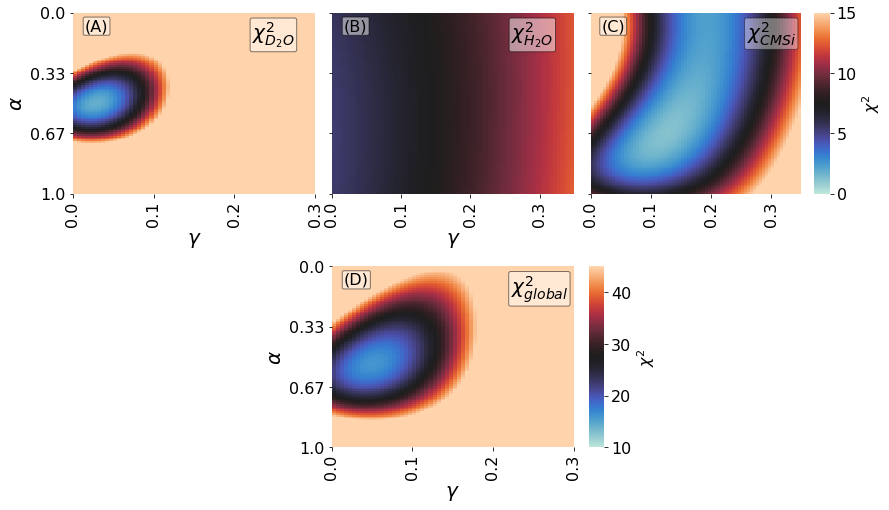

In [15]:
fig   = plt.figure(figsize=(14, 8))
annotate_pos = (0.05,0.9)
ouput_object_name = "output_data.pkl"
out_path          =  "./example-data/"
width_ratios = np.ones (40)
width_ratios [-1] = 1.2

gs    = fig.add_gridspec(nrows=2, ncols=40, width_ratios=width_ratios,
                         wspace=5, hspace=0.4)

with open(out_path + ouput_object_name, 'rb') as inp: R_amber_mch = pickle.load(inp)
# Xticks positions
xticks = np.linspace (0.0, 0.5, 6)
xticks = np.round (xticks,2)
xticks_positions = np.linspace (0, 100, 6)
## Yticks positions

# Xticks positions
yticks = np.linspace (0.0, 1.0, 4)
yticks = np.round (yticks,2)
yticks_positions = np.linspace (0, 100, 4)

#######################
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
plt.rc('axes', labelsize=16)
vmax = 15
end = 13
ax1 = fig.add_subplot(gs[0, 0:end])



Chi_sq = get_chi_array (R_object=R_amber_mch, solvent="d2o")

sns.heatmap(Chi_sq,  yticklabels=False, vmin=0, vmax=vmax,linewidths=0,
            cbar=False, cbar_kws={"aspect":12, "label":"$\chi^2$"},cmap="icefire", ax=ax1);

plt.xticks ( xticks_positions,xticks, fontsize=16);

plt.yticks ( yticks_positions, yticks, fontsize=16);

#ax1.set_title ("$\chi^2_{D_2O}$", fontsize=20,
 #              bbox=dict(boxstyle="round,pad=0.1",
  #                       fc="white", ec=None, lw=1, alpha=0.5), pad=10)

        
ax1.annotate ("$\chi^2_{D_2O}$", xycoords = "axes fraction", 
          xy = (0.74, 0.85),bbox=dict(boxstyle="round,pad=0.1",
                                    fc="white", ec=None, lw=1, alpha=0.5),fontsize=20);

ax1.annotate ("(A)", xycoords = "axes fraction", 
          xy =annotate_pos,bbox=dict(boxstyle="round,pad=0.1", fc="white", ec=None, lw=1, alpha=0.5),fontsize=16);

plt.xlabel ("$\gamma$", fontsize=20)
plt.ylabel ("$\\alpha$", fontsize=20)
plt.xlim (0, 60)

start=end
end += 13
ax1 = fig.add_subplot(gs[0, start:end])

Chi_sq = get_chi_array (R_object=R_amber_mch, solvent="h2o")

sns.heatmap(Chi_sq,  yticklabels=False, vmin=0, vmax=vmax,linewidths=0,
            cbar=False, cbar_kws={"aspect":12, "label":"$\chi^2$"},cmap="icefire", ax=ax1);

yticks = ['']*4
plt.yticks ( yticks_positions, yticks, fontsize=0);
plt.xticks ( xticks_positions,xticks, fontsize=16);
plt.xlim (0, 70)
#ax1.set_title ("$\chi^2_{H_2O}$", fontsize=20,
               #bbox=dict(boxstyle="round,pad=0.1",
                         #fc="white", ec=None, lw=1, alpha=0.5), pad=0)
        
ax1.annotate ("$\chi^2_{H_2O}$", xycoords = "axes fraction", 
          xy = (0.74, 0.85),bbox=dict(boxstyle="round,pad=0.1",
                                    fc="white", ec=None, lw=1, alpha=0.5),fontsize=20);



ax1.annotate ("(B)", xycoords = "axes fraction", 
          xy =annotate_pos,bbox=dict(boxstyle="round,pad=0.1", fc="white", ec=None, lw=1, alpha=0.5),fontsize=16);
plt.xlabel ("$\gamma$", fontsize=20)


start=end
end += 13
ax1 = fig.add_subplot(gs[0, start:end+1])


Chi_sq = get_chi_array (R_object=R_amber_mch, solvent="cmsi")

sns.heatmap(Chi_sq,  yticklabels=False, vmin=0, vmax=vmax,linewidths=0,
            cbar=True, cbar_kws={"aspect":12, "label":"$\chi^2$","ticks":[0,5,10,15]},cmap="icefire", ax=ax1);

#ax1.set_title ("$\chi^2_{CMSi}$", fontsize=20,
     #          bbox=dict(boxstyle="round,pad=0.1",
     #                    fc="white", ec=None, lw=1, alpha=0.5), pad=0)


ax1.annotate ("$\chi^2_{CMSi}$", xycoords = "axes fraction", 
          xy = (0.74, 0.85),bbox=dict(boxstyle="round,pad=0.1",
                                    fc="white", ec=None, lw=1, alpha=0.4),fontsize=20);


plt.yticks ( yticks_positions, yticks, fontsize=0);
ax1.annotate ("(C)", xycoords = "axes fraction", 
          xy =annotate_pos,bbox=dict(boxstyle="round,pad=0.1", fc="white", ec=None, lw=1, alpha=0.5),fontsize=16);

plt.xticks ( xticks_positions,xticks, fontsize=16);
plt.xlim (0, 70)
R_amber.water_fraction [ np.argmin (R_amber.h2o_chi)]


#############Global


xticks = np.linspace (0.0, 0.5, 6)
xticks = np.round (xticks,2)
xticks_positions = np.linspace (0, 100, 6)
## Yticks positions

# Xticks positions
yticks = np.linspace (0.0, 1.0, 4)
yticks = np.round (yticks,2)
yticks_positions = np.linspace (0, 100, 4)

#######################
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
plt.rc('axes', labelsize=16)

ax1 = fig.add_subplot(gs[1, 13:29])

Chi_sq = get_chi_array (R_object=R_amber_mch)

sns.heatmap(Chi_sq,  yticklabels=False, vmin=10, vmax=45,linewidths=0,
            cbar=True, cbar_kws={"aspect":12, "label":"$\chi^2$"},cmap="icefire", ax=ax1);

plt.xticks ( xticks_positions,xticks, fontsize=16);

plt.yticks ( yticks_positions, yticks, fontsize=16);
plt.xlim (0, 60)
plt.xlabel ("$\gamma$", fontsize=20)
plt.ylabel ("$\\alpha$", fontsize=20)

#ax1.set_title ("$\chi^2_{global}$", fontsize=20,
 #              bbox=dict(boxstyle="round,pad=0.1", fc="white", ec=None, lw=1, alpha=0.5), pad=0)
plt.xlabel ("$\gamma$", fontsize=20)


ax1.annotate ("(D)", xycoords = "axes fraction", 
          xy =annotate_pos,bbox=dict(boxstyle="round,pad=0.1", fc="white", ec=None, lw=1, alpha=0.5),fontsize=16);


ax1.annotate ("$\chi^2_{global}$", xycoords = "axes fraction", 
          xy = (0.74, 0.85),bbox=dict(boxstyle="round,pad=0.1",
                                    fc="white", ec=None, lw=1, alpha=0.5),fontsize=20);

#plt.savefig ("./figures/S5.png", dpi=600, bbox_inches='tight') 


#ax2.set_yticklabels([])
#ax3.set_yticklabels([])

plt.savefig ("./example-data/metric_space.png", dpi=800, bbox_inches='tight')